In [9]:
%run wikidata_functions.ipynb

[('Q146', 'house cat', 'domesticated feline'), ('Q4167836', 'Wikimedia category', "use with 'instance of' (P31) for Wikimedia category"), ('Q387278', 'Kellas cat', 'cat'), ('Q300918', 'cat', 'Unix utility that concatenates and lists files'), ('Q10813994', 'Tsim Tung Brother Cream', 'cat')]
[('Q76', 'Barack Obama', 'president of the United States from 2009 to 2017'), ('Q61909968', 'Barack Obama', 'Wikimedia disambiguation page')]
3


In [2]:
import pandas as pd
import numpy as np
import spacy
from spacy.matcher import Matcher 
import spacy_universal_sentence_encoder
import claucy   
from bs4 import BeautifulSoup

2023-12-09 00:35:27.457176: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import re
import random
import pickle
import time
import functools

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

In [70]:
# function that takes output of get_opt_sentences and returns half true sentences, half false sentences
# input: contents, false replacements
def process_gpt_contents(contents, reps=None):
    assert len(contents) == 42
    tsents = [0]*21
    fsents = [0]*21

    for i, key in enumerate(contents.keys()):
        content = contents[key]
        
        if i >= 21:
            if reps:
                rep = random.choice(reps)
            else:
                q1, q2, p = key
                q1 = get_label_from_qid2(q1)
                q2 = get_label_from_qid2(q2)
                p = get_property_from_pid2(p)
                
                rep = input(f"Replace the object in the triple {q1, p, q2} to make it false.")
            subj = get_label_from_qid(key[1])
            content = re.sub(subj, rep, content)
            
        sentences = content.split("\n")

        if i < 21:
            tsents[i] = sentences
        else:
            fsents[i-21] = sentences

    return tsents, fsents

https://github.com/explosion/spaCy/blob/master/spacy/glossary.py

https://web.archive.org/web/20190206204307/https://www.clips.uantwerpen.be/pages/mbsp-tags

Distant supervision for relation extraction without labeled data

In [13]:
def spacy_pos_map(pos):
    if pos in ["NOUN", "PRON", "PROPN", "NN", "NND", "NNPS", "NNS", "PRP", "PRP$"]:
        return "NOUN"
    elif pos in ["VERB", "MD", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]:
        return "VERB"
    elif pos in ["ADV", "RB", "RBR", "RBS", "RP"]:
        return "ADV"
    elif pos in ["ADJ", "JJ", "JJR", "JJS"]:
        return "ADJ"
    elif pos in ["NUM", "CD"]:
        return "NUM"
    elif pos == "FW":
        return "FW"
    else:
        return "EE" # everything else 

In [14]:
def spacy_pos_map2(pos):
    if pos in ["NOUN", "PRON", "PROPN", "NN", "NND", "NNPS", "NNS", "PRP", "PRP$"]:
        return 1
    elif pos in ["VERB", "MD", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]:
        return 2
    elif pos in ["ADV", "RB", "RBR", "RBS", "RP"]:
        return 3
    elif pos in ["ADJ", "JJ", "JJR", "JJS"]:
        return 4
    elif pos in ["NUM", "CD"]:
        return 5
    elif pos == "FW":
        return 6
    else:
        return 7 # everything else 

In [15]:
# EVERY SENTENCE SHOULD BE SHORTER THAN 100 TOKENS (LIMIT)
# 2 NOUNS ONLY
def sentences_to_Xy(sents, labels, subj, nlp, use, limit=100):
    assert(len(sents) == len(labels))
    
    n = len(sents)
    n_fts = limit + limit + 8 + 1 + 512
    # words + pos + left/right + order of noun + universal sentence encoding
    
    X = np.zeros((n, n_fts))
    y = np.zeros(n)

    i = 0
    for z, sent in enumerate(sents):
        doc = nlp(sent)

        # two nouns
        count = 0 # nouns seen/started
        compound = False # currently in a compound word
        n_ind = [[-1, -1], [-1, -1]] #starting and end indices of nouns
        
        for k, tok in enumerate(doc):
            p = spacy_pos_map(tok.pos_)
            if p == "NOUN":
                if count == 0: #new noun
                    count += 1
                    n_ind[0][0] = k
                    if tok.dep_ == "compound":
                        compound = True
                    else:
                        n_ind[0][1] = k
                elif count == 1:
                    if compound: #continuation
                        n_ind[0][1] = k
                        if tok.dep_ != "compound": 
                            compound = False
                            
                    else: #new noun
                        count += 1
                        n_ind[1][0] = k
                        if tok.dep_ == "compound":
                            compound = True
                        else:
                            n_ind[1][1] = k  
                elif count == 2:
                    if compound: #continuation
                        n_ind[1][1] = k
                        if tok.dep_ != "compound": 
                            compound = False

                    else:  #third noun
                        count += 1
                        break
                        
            if count == 3: continue # more than 2 nouns
                
            if n_ind[1][1] - n_ind[0][0] + 1 > limit: continue # too many tokens, over feature limit

        start, end = n_ind[0][0], n_ind[1][1]
        # words and pos
        for j in range(n_ind[1][1] - n_ind[0][0] + 1):
            X[i][j] = int.from_bytes(str(doc[start+j]).encode(), 'big')
            X[i][j+limit] = spacy_pos_map2(doc[start+j].pos_)

        # left and right
        if n_ind[0][0] > 0: #left1
            X[i][2*limit] = int.from_bytes(str(doc[start-1]).encode(), 'big')
            X[i][2*limit+1] = spacy_pos_map2(doc[start-1].pos_)
        if n_ind[0][0] > 1: #left2
            X[i][2*limit+2] = int.from_bytes(str(doc[start-2]).encode(), 'big')
            X[i][2*limit+3] = spacy_pos_map2(doc[start-2].pos_)
        if n_ind[1][1] < len(doc)-1: #right1
            X[i][2*limit+4] = int.from_bytes(str(doc[end+1]).encode(), 'big')
            X[i][2*limit+5] = spacy_pos_map2(doc[end+1].pos_)
        if n_ind[1][1] < len(doc)-2: #right2
            X[i][2*limit+6] = int.from_bytes(str(doc[end+2]).encode(), 'big')
            X[i][2*limit+7] = spacy_pos_map2(doc[end+2].pos_)

        #order
        obj_sem = use("obj")
        n1_sem = use(str(doc[start:n_ind[0][1]+1]))
        n2_sem = use(str(doc[n_ind[1][0]:end+1]))

        X[i][2*limit+8] = 0 if obj_sem.similarity(n1_sem) > obj_sem.similarity(n2_sem) else 1

        #universal sentence encoding
        sem = use(str(doc[n_ind[0][0]:n_ind[1][1]+1]))
        X[i][2*limit+9:] = sem.vector

        # label
        y[i] = 1 if labels[z] else 0
        i += 1

    return X[:i], y[:i]

In [16]:
def sentences_to_Xy(sents, labels, nlp, use, limit=100):
    assert(len(sents) == len(labels))
    
    n = len(sents)
    n_fts = limit + limit + 512
    # words + pos + universal sentence encoding
    
    X = np.zeros((n, n_fts))
    y = np.zeros(n)

    i = 0
    for z, sent in enumerate(sents):
        doc = nlp(sent)
        if len(doc) > limit: continue #too long
            
        for k, tok in enumerate(doc):
            X[i][k] = int.from_bytes(str(tok).encode(), 'big')
            X[i][k + limit] = spacy_pos_map2(tok.pos_)
        
        sem = use(sent) #universal sentence encoding
        X[i][2*limit:] = sem.vector

        # label
        y[i] = 1 if labels[z] else 0
        i += 1

    return X[:i], y[:i]

In [17]:
nlp = spacy.load('en_core_web_md')
claucy.add_to_pipe(nlp)
use= spacy.load('en_use_md')

In [91]:
contents = pickle.load(open('gpt_responses/P2936.pickle', 'rb'))

# reps = ["ASIA", "UNASIA", "EARTHSEA", "SPACE", "EARTH", "ARTIC", "CORNELL", "the Ivy League", "the Blue League", "SADO", "the Climate Group"]
# reps += ["New York Times", "Nobel Organization", "SEC", "FDA", "PLA", "SEA"]

tsents, fsents = process_gpt_contents(contents)

tsents = list(functools.reduce(lambda x, y: x + y, tsents, []))
fsents = list(functools.reduce(lambda x, y: x + y, fsents, []))

tX, ty = sentences_to_Xy(tsents, [True] * len(tsents), nlp, use, limit=50)
fX, fy = sentences_to_Xy(fsents, [False] * len(fsents), nlp, use, limit=50)

X = np.concatenate((tX, fX), axis=0)
y = np.concatenate((ty, fy), axis=0)

Replace the object in the triple ('Russia', 'language used', 'Khakas') to make it false. Chinese
Replace the object in the triple ('Philippines', 'language used', 'Kapampangan') to make it false. French
Replace the object in the triple ('Russia', 'language used', 'Andi') to make it false. Cantonese
Replace the object in the triple ('India', 'language used', 'Punjabi') to make it false. Mongolian
Replace the object in the triple ('Democratic Republic of the Congo', 'language used', 'Kongo') to make it false. Thai
Replace the object in the triple ('Ghana', 'language used', 'Nyangbo') to make it false. Afrikaans
Replace the object in the triple ('Brunei', 'language used', 'Hakka Chinese') to make it false. Arabic
Replace the object in the triple ('India', 'language used', 'Angika') to make it false. Polish
Replace the object in the triple ('India', 'language used', 'Magahi') to make it false. Turkish
Replace the object in the triple ('Vanuatu', 'language used', 'Aulua') to make it false. 

In [92]:
pickle.dump(X, open('models/data/P2936_X.pickle', 'wb'))
pickle.dump(y, open('models/data/P2936_y.pickle', 'wb'))

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/21, random_state=42)

In [96]:
logreg2000 = LogisticRegression(random_state=42, solver='saga', max_iter=10000)
logreg2000.fit(X_train, y_train)


LogisticRegression(max_iter=10000, random_state=42, solver='saga')

In [97]:
pickle.dump(logreg2000, open('models/logreg_P2936_2000.pickle', 'wb'))

In [98]:
logreg2000 = pickle.load(open('models/logreg_P2936_2000.pickle', 'rb'))
y_pred = logreg2000.predict(X_test)
precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.3125, 0.15151515151515152, 0.20408163265306123, None)

In [99]:
X_train, y_train = X_train[:1500], y_train[:1500]
logreg1500 = LogisticRegression(random_state=42, solver='saga', max_iter=10000)
logreg1500.fit(X_train, y_train)


LogisticRegression(max_iter=10000, random_state=42, solver='saga')

In [100]:
pickle.dump(logreg1500, open('models/logreg_P2936_1500.pickle', 'wb'))

In [101]:
logreg1500 = pickle.load(open('models/logreg_P2936_1500.pickle', 'rb'))
y_pred = logreg1500.predict(X_test)

In [102]:
precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.37037037037037035, 0.30303030303030304, 0.3333333333333333, None)

In [103]:
X_train, y_train = X_train[:1000], y_train[:1000]
logreg1000 = LogisticRegression(random_state=42, solver='saga', max_iter=10000)
logreg1000.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42, solver='saga')

In [104]:
pickle.dump(logreg1000, open('models/logreg_P2936_1000.pickle', 'wb'))

In [105]:
logreg1000 = pickle.load(open('models/logreg_P2936_1000.pickle', 'rb'))
y_pred = logreg1000.predict(X_test)
precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.39655172413793105, 0.3484848484848485, 0.3709677419354839, None)

In [106]:
X_train, y_train = X_train[:500], y_train[:500]
logreg500 = LogisticRegression(random_state=42, solver='saga', max_iter=10000)
logreg500.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42, solver='saga')

In [107]:
pickle.dump(logreg500, open('models/logreg_P2936_500.pickle', 'wb'))

In [108]:
logreg500 = pickle.load(open('models/logreg_P2936_500.pickle', 'rb'))
y_pred = logreg500.predict(X_test)
precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.36764705882352944, 0.3787878787878788, 0.373134328358209, None)

In [109]:
scores = {}
scores['P530'] = {}
scores['P530'][2000] = (0.5172413793103449, 0.5357142857142857, 0.5263157894736843, None)
scores['P530'][1500] = (0.5272727272727272, 0.5178571428571429, 0.5225225225225225, None)
scores['P530'][1000] = (0.5483870967741935, 0.30357142857142855, 0.3908045977011494, None)
scores['P530'][500] = (0.3125, 0.15151515151515152, 0.20408163265306123, None)
scores['P463'] = {}
scores['P463'][2000] = (0.5306122448979592, 0.8125, 0.6419753086419753, None)
scores['P463'][1500] = (0.5321100917431193, 0.90625, 0.6705202312138729, None)
scores['P463'][1000] = (0.5402298850574713, 0.734375, 0.6225165562913907, None)
scores['P463'][500] = (0.37037037037037035, 0.30303030303030304, 0.3333333333333333, None)
scores['P150'] = {}
scores['P150'][2000] = (0.5094339622641509, 0.4909090909090909, 0.5, None)
scores['P150'][1500] = (0.46296296296296297, 0.45454545454545453, 0.4587155963302752, None)
scores['P150'][1000] = (0.4444444444444444, 0.43636363636363634, 0.4403669724770642, None)
scores['P150'][500] = (0.40625, 0.23636363636363636, 0.2988505747126437, None)
scores['P2936'] = {}
scores['P2936'][2000] = (0.5094339622641509, 0.4909090909090909, 0.5, None)
scores['P2936'][1500] = (0.46296296296296297, 0.45454545454545453, 0.4587155963302752, None)
scores['P2936'][1000] = (0.39655172413793105, 0.3484848484848485, 0.3709677419354839, None)
scores['P2936'][500] = (0.36764705882352944, 0.3787878787878788, 0.373134328358209, None)

In [110]:
import matplotlib.pyplot as plt

In [115]:
x = [500, 1000, 1500, 2000]
y = {}
for key in scores.keys():
    y[key] = {}
    y[key]['p'] = [scores[key][xi][0] for xi in x]
    y[key]['r'] = [scores[key][xi][1] for xi in x]
    y[key]['f'] = [scores[key][xi][2] for xi in x]

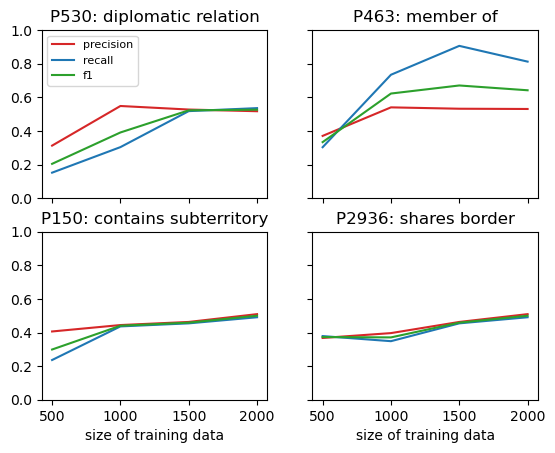

In [141]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(x, y['P530']['p'], 'tab:red', label='precision')
axs[0, 0].plot(x, y['P530']['r'], 'tab:blue', label='recall')
axs[0, 0].plot(x, y['P530']['f'], 'tab:green', label='f1')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_title('P530: diplomatic relation')
axs[0, 1].plot(x, y['P463']['p'], 'tab:red')
axs[0, 1].plot(x, y['P463']['r'], 'tab:blue')
axs[0, 1].plot(x, y['P463']['f'], 'tab:green')
axs[0, 1].set_title('P463: member of')
axs[0, 1].set_ylim(0, 1)
axs[1, 0].plot(x, y['P150']['p'], 'tab:red')
axs[1, 0].plot(x, y['P150']['r'], 'tab:blue')
axs[1, 0].plot(x, y['P150']['f'], 'tab:green')
axs[1, 0].set_title('P150: contains subterritory')
axs[1, 0].set_ylim(0, 1)
axs[1, 1].plot(x, y['P2936']['p'], 'tab:red')
axs[1, 1].plot(x, y['P2936']['r'], 'tab:blue')
axs[1, 1].plot(x, y['P2936']['f'], 'tab:green')
axs[1, 1].set_title('P2936: shares border')
axs[1, 1].set_ylim(0, 1)

axs[0, 0].legend(fontsize=8, loc ="upper left")

for ax in axs.flat:
    # ax.set(xlabel='x-label', ylabel='y-label')
    ax.set(xlabel='size of training data')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.savefig('scores.png')